# Hindmarsh-Rose fit into Hodgkin-Huxley

In [1]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython' 

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Input Data Preparation

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

time_unit = 1*ms
dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [4]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [5]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(30*ms)

In [7]:
voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))*2


inp_trace = np.array([input_current0])
n0, n1 = inp_trace.shape

out_trace = np.array([voltage[:n1]])

In [8]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.]])

In [9]:
out_trace

array([[-65.04040019, -67.81860435, -64.56652507, ..., -81.23508985,
        -74.43203488, -73.4352381 ]])

# Model Fitting 

In [38]:
eqs = Equations('''
dx/dt = (y - a*x**3 + b*x**2 + I/nA - z)/time_unit : 1
dy/dt = (c - d*x**2 - y)/time_unit : 1
dz/dt = r*(s*(x - x_1) - z)/time_unit : 1
v = (base + x * scale)*mV :volt
base: 1 (constant)
scale: 1 (constant)
''',
x_1 = -1.6,
a = 1, b = , c = 1, d = 5,
r = 0.001, s = 4, 
time_unit=1*ms)

# Basic Prove of Concept

In [39]:
start_scope()
n_opt = NevergradOptimizer(method='PSO')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   method='rk4',
                                   scale = [20, 40], 
                                   base = [-20, -10],
                                   param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                                   n_rounds=3, n_samples=10, optimizer=n_opt, metric=metric
                                   )

res

round 0 with error [2.02987365 2.02987365]
round 1 with error [1.41916156 1.41916156]
round 2 with error []


{'scale': 20.91966256462015, 'base': -15.74219846174319}

In [40]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='rk4', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                    )

x = fits/mV

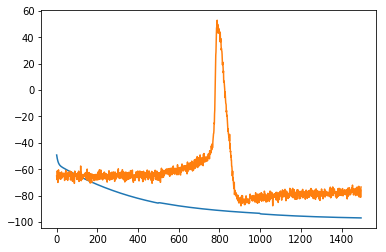

In [41]:
plot(x.transpose())
plot(out_trace.transpose());

## Bigger Range

In [34]:
start_scope()
n_opt = NevergradOptimizer(method='PSO')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   method='rk4',
                                   scale = [0, 60], 
                                   base = [-30, 10],
                                   param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                                   n_rounds=3, n_samples=20, optimizer=n_opt, metric=metric
                                   )

res

round 0 with error [0.7441264 0.7441264]
round 1 with error [0.72383175 0.72383175]
round 2 with error [0.75396147 1.70640389 0.71219955 0.71219955 2.19282246 0.73100151
 4.93189057 2.57278337 3.81603186 1.13509601 2.57278337 1.93384269
 2.57278337]


{'scale': 23.329098553590818, 'base': -30.0}

In [35]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='rk4', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                    )

x = fits/mV

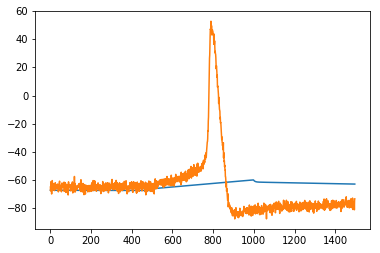

In [36]:
plot(x.transpose())
plot(out_trace.transpose());

### More Parameters

In [37]:
eqs = Equations('''
dx/dt = (y - a*x**3 + b*x**2 + rescale * I/nA - z)/time_unit : 1
dy/dt = (c - d*x**2 - y)/time_unit : 1
dz/dt = r*(s*(x - x_1) - z)/time_unit : 1
v = (base + x * scale)*mV :volt
base: 1 (constant)
scale: 1 (constant)
rescale: 1 (constant)
''',
x_1 = -1.6,
a = 1,
b = 3, 
c = 1, 
d = 5,
r = 0.001, 
s = 4, 
time_unit=1*ms)

ValueError: Cannot replace model variable "r" with a value

In [27]:
start_scope()
n_opt = NevergradOptimizer(method='PSO')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   method='rk4',
                                   scale = [0, 60], 
                                   base = [-30, 10],
                                   rescale = [1,5],
                                   param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                                   n_rounds=3, n_samples=20, optimizer=n_opt, metric=metric
                                   )

res

round 0 with error [1.96130474 1.96130474]
round 1 with error [1.57330666 1.57330666]
round 2 with error []


{'scale': 23.784598577028653, 'base': -27.276832971160868}

In [28]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='rk4', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                    )

x = fits/mV

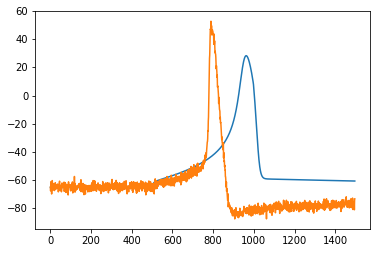

In [29]:
plot(x.transpose())
plot(out_trace.transpose());